<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/EXample_SVM_Primal_Dual_Classification_Corn_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Developed by Alireza Soroudi
alireza.soroudi@gmail.com

Linkedin News letter : https://www.linkedin.com/newsletters/optimization-in-open-source-6874020019009859585/

Git hub: https://github.com/OptimizationExpert/Pyomo


Data Source https://www.kaggle.com/datasets/muratkokludataset/pumpkin-seeds-dataset


In [1]:
!pip install pyomo
import numpy as np
from random import randint
import random
import time
from math import ceil
import matplotlib.pyplot as plt # Data visualization
from pyomo.environ import *
import numpy as np
import pandas as pd


!wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
opt = SolverFactory('ipopt', executable='/content/ipopt')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.9 MB/s eta 0:00:00


In [2]:
df = pd.read_csv("/content/corn_seed.csv")
df

FileNotFoundError: [Errno 2] No such file or directory: '/content/corn_seed.csv'

In [ ]:
df["Class"].unique()

In [ ]:
Y = []
#df['output'] = Y
labels = [l for l in df["Class"].unique()]
#Y = {i:labels.index(df.loc[i,"Class"]) for i in range(len(df))}
df["output"] = [labels.index(df.loc[i,"Class"]) for i in range(len(df))]
df = df.drop(columns = ["Class"])

df

# Clean the data

In [ ]:
J_set = [c for c in df.columns if c not in ["output"] ]

J_set

#Data Processing




In [ ]:
df

In [ ]:
for c in J_set:
  df[c] = (df[c]-df[c].mean())/df[c].std()
df

In [ ]:
n = len(df)
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
test_df.head(), len(test_df)

In [ ]:
len(train_df)

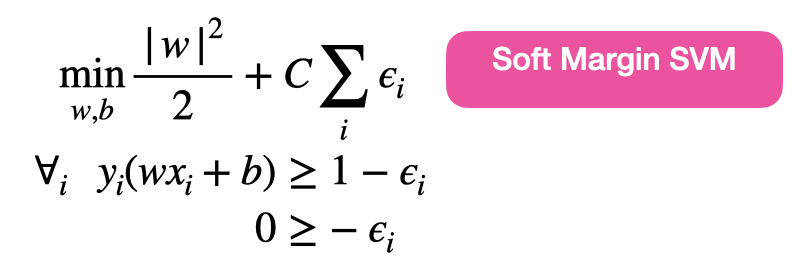

In [ ]:
I_set = [i for i in train_df.index]
m = len(J_set)
Y={i:2*train_df.loc[i,"output"]-1 for i in I_set}

In [ ]:
model = AbstractModel()
model.i = Set(initialize= I_set)
model.j= Set(initialize= J_set)
C = 0.5
def rule_x(model,i,j):
  return train_df.loc[i,j]
model.X = Param(model.i,model.j,initialize= rule_x, mutable = True)

model.w = Var(model.j, bounds=(-200,200), within=Reals)
model.beta = Var(bounds=(-300,300), within=Reals)

model.eps = Var(model.i, bounds=(0,200), within=Reals)

def rule_con1(model,i):
  return  Y[i]*( sum(model.w[j]*model.X[i,j] for j in model.j)+ model.beta) >= 1- model.eps[i]
model.con1= Constraint(model.i, rule=rule_con1)

def rule_of(model):
  return 0.5*sum(model.w[j]**2 for j in model.j) + C * sum(model.eps[i] for i in model.i)
model.obj = Objective(rule=rule_of, sense=minimize)
instance = model.create_instance()
st= time.time()
result = opt.solve(instance)
ft= time.time()
print("time", ft-st)
print("obj", value(instance.obj))

In [ ]:
error = 0
for i in test_df.index:
  actual = 2*test_df.loc[i,"output"]-1
  predict = sum(test_df.loc[i,j]*value(instance.w[j]) for j in instance.j) + value(instance.beta)
  if predict >=1:
    predict = 1
  else:
    predict = -1
  error += 1 if abs(actual-predict)>0 else 0
print("error", error/len(test_df))

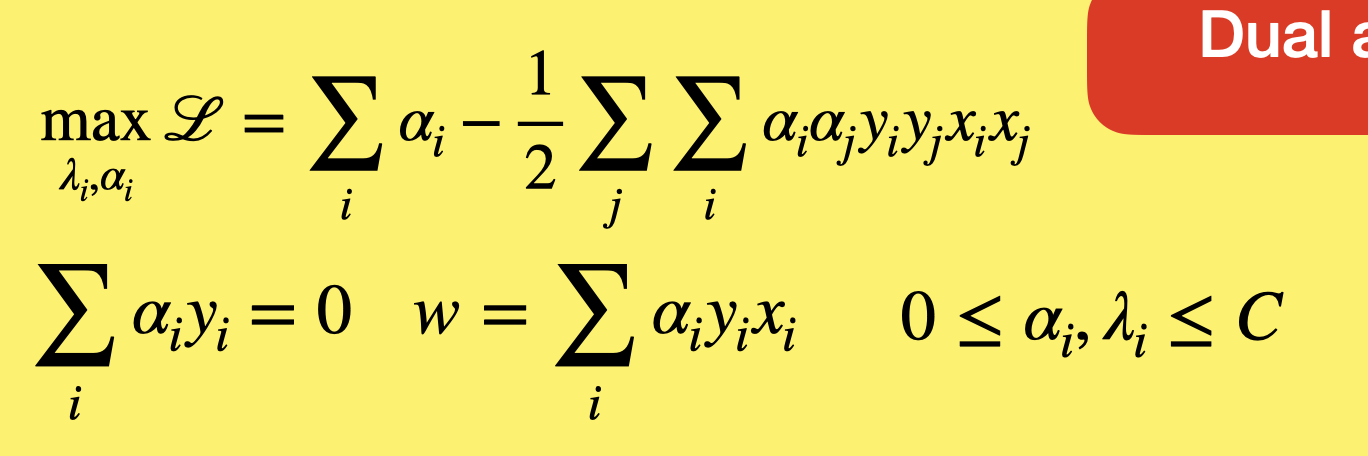